Define database, import necessary packages

In [174]:
db_name = 'City_Energy_Data'
import mysql.connector 
import pandas as pd
import config
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [175]:
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.passwd,
    database = db_name
)
cur = cnx.cursor()

In [176]:
stmt = """
SELECT p.city, p.state, p.population, r.housing_units, r.elec_mwh, r.elec_lb_ghg
FROM population_data AS p
INNER JOIN residential_energy_A AS r ON p.city_id=r.city_id;
"""
cur.execute(stmt)
clean_rdf = pd.DataFrame(cur.fetchall())
clean_rdf.columns = [x[0] for x in cur.description]

In [177]:
clean_rdf['population'] = clean_rdf['population'].apply(lambda x: x.replace(',', ''))
clean_rdf['population'] = clean_rdf['population'].astype(int)

In [178]:
def elec_person(population, elec_mwh):
    elec_person = None 
    try:
        elec_person = elec_mwh / population
    except:
        elec_mwh == 0 or population == 0
    return elec_person

def ghg_person(population, lb_ghg):
    ghg_person = None
    try:
        ghg_person = lb_ghg / population
    except:
        lb_ghg == 0 or population == 0
    return ghg_person
        

In [179]:
clean_rdf['elec_per_person'] = clean_rdf.apply(lambda x: elec_person(x.population, x.elec_mwh), axis=1)

In [180]:
clean_rdf['ghg_per_person'] = clean_rdf.apply(lambda x: ghg_person(x.population, x.elec_lb_ghg), axis=1)

In [181]:
clean_rdf.head()

,city,state,population,housing_units,elec_mwh,elec_lb_ghg,elec_per_person,ghg_per_person
0,New York,NY,8363710,3128246.0,14872960.0,2.147484e+09,1.778273,256.762088
1,Los Angeles,CA,3833995,1355074.0,9043891.0,2.147484e+09,2.358869,560.116444
2,Chicago,IL,2853114,1042539.0,7211287.0,2.147484e+09,2.527514,752.680631
3,Houston,TX,2242193,829402.0,10547389.0,2.147484e+09,4.704050,957.760392
4,Phoenix,AZ,1567924,537950.0,7371754.0,2.147484e+09,4.701602,1369.635038


Drop Outliers

In [182]:
clean_rdf.drop(clean_rdf[clean_rdf.population > 900000 ].index, inplace = True)
clean_rdf.drop(clean_rdf[clean_rdf.elec_per_person > 10].index, inplace = True)

/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequen

Text(0.5, 0, 'MWh per Individual')

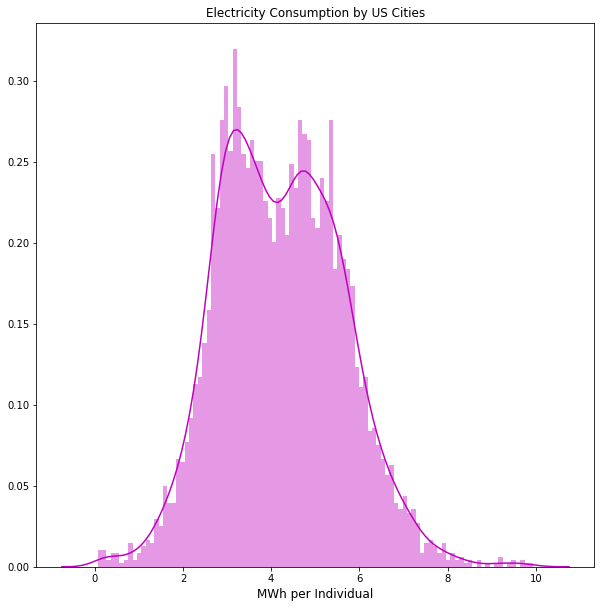

In [183]:
plt.figure(figsize=(10,10))
sns.distplot(clean_rdf['elec_per_person'], bins=100, color='m').set_title('Electricity Consumption by US Cities')
plt.xlabel('MWh per Individual', fontsize=12)






In [184]:
import math
import scipy.stats as stats

In [238]:
populous_bois = clean_rdf.sort_values('population', ascending=False).head(250)

/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


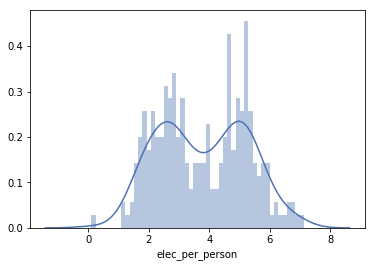

In [186]:
sns.distplot(populous_bois['elec_per_person'], bins=50)

In [243]:
mu = clean_rdf['elec_per_person'].mean()
sigma = clean_rdf['elec_per_person'].std() 
n= len(populous_bois)
x_bar = populous_bois['elec_per_person'].mean()
z = (x_bar - mu)/(sigma/math.sqrt(n))

p = stats.norm.cdf(z)

p,z

(4.592813777817618e-07, -4.908327706285293)

In [188]:
rural_bois = clean_rdf.sort_values('population', ascending=True).head(250)

/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


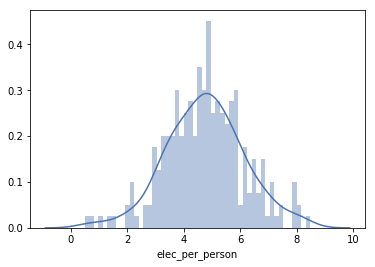

In [189]:
sns.distplot(rural_bois['elec_per_person'], bins=50)

In [244]:
mu = clean_rdf['elec_per_person'].mean()
sigma = clean_rdf['elec_per_person'].std() 
n= len(rural_bois)
x_bar = rural_bois['elec_per_person'].mean()
z = (x_bar - mu)/(sigma/math.sqrt(n))
p = stats.norm.cdf(z)

p,z

(0.9999999993358756, 6.063942232448783)

In [191]:
show = [clean_rdf['elec_per_person'].mean(), populous_bois['elec_per_person'].mean(), rural_bois['elec_per_person'].mean()]
show

[4.2179752294281805, 3.7842426855114017, 4.7538255735843835]

In [192]:
import numpy

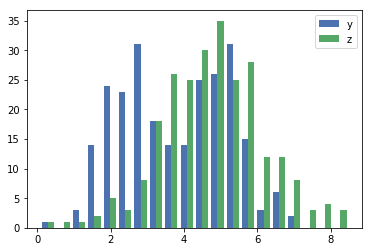

In [193]:
plt.style.use('seaborn-deep')

y = populous_bois['elec_per_person']
z = rural_bois['elec_per_person']
bins = np.linspace(0, 10, 30)

plt.hist([y, z], bins=20, label=['y', 'z'])
plt.legend(loc='upper right')
plt.show()

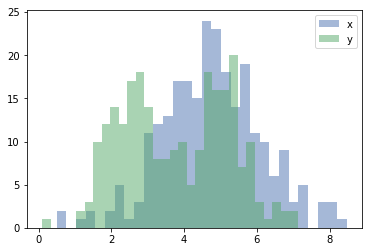

In [194]:
bins = numpy.linspace(0, 10, 100)

plt.hist(z, bins=30, alpha=0.5, label='x')
plt.hist(y, bins=30, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.show()

/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


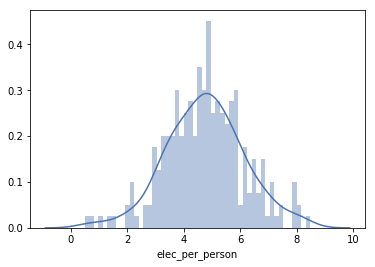

In [195]:
sns.distplot(rural_bois['elec_per_person'], bins=50)

/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


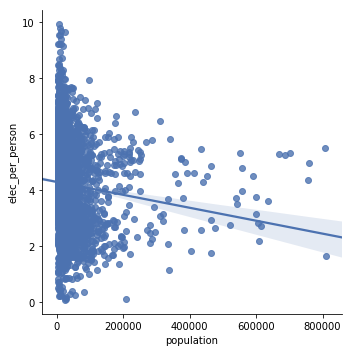

In [196]:
x = sns.lmplot(x='population', y='elec_per_person', data= clean_rdf)
x_ticks=1000000
fig = x.fig 

/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(27.125, 0.5, 'MWh per Individual')

<Figure size 720x720 with 0 Axes>

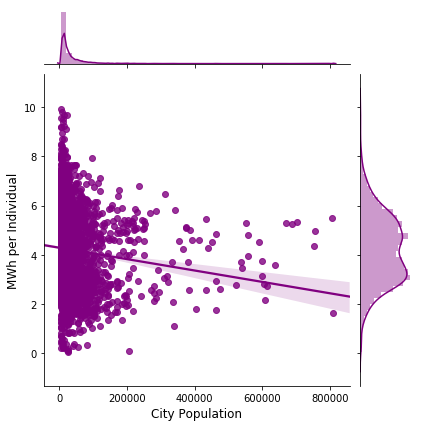

In [230]:
plt.figure(figsize=(10,10))
sns.jointplot(x='population', y='elec_per_person', data= clean_rdf, kind="reg", color="purple")
plt.xlabel('City Population', fontsize=12)
plt.ylabel('MWh per Individual', fontsize=12)


In [198]:
clean_rdf['elec_per_person'].describe()

count    4845.000000
mean        4.217975
std         1.397200
min         0.066207
25%         3.158969
50%         4.167347
75%         5.214609
max         9.942757
Name: elec_per_person, dtype: float64

/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


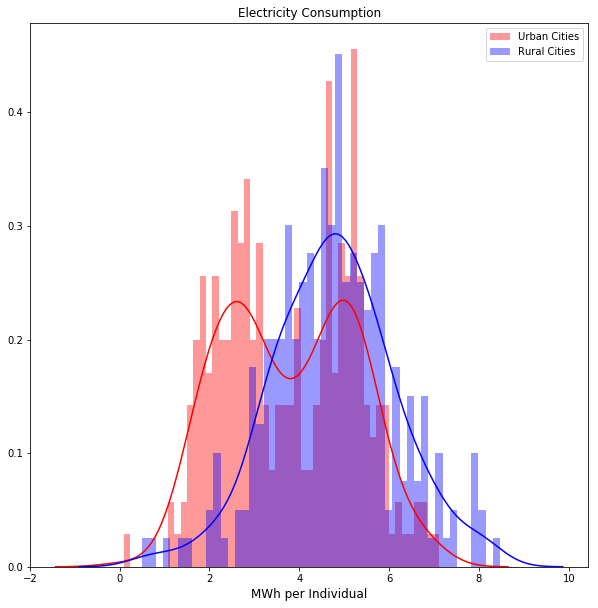

In [199]:
plt.figure(figsize=(10,10))
sns.distplot(y, label='Urban Cities', color='r', bins=50).set_title('Electricity Consumption')
sns.distplot(z, label='Rural Cities', color='b', bins=50)
plt.xlabel('MWh per Individual', fontsize=12)
plt.legend();

/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


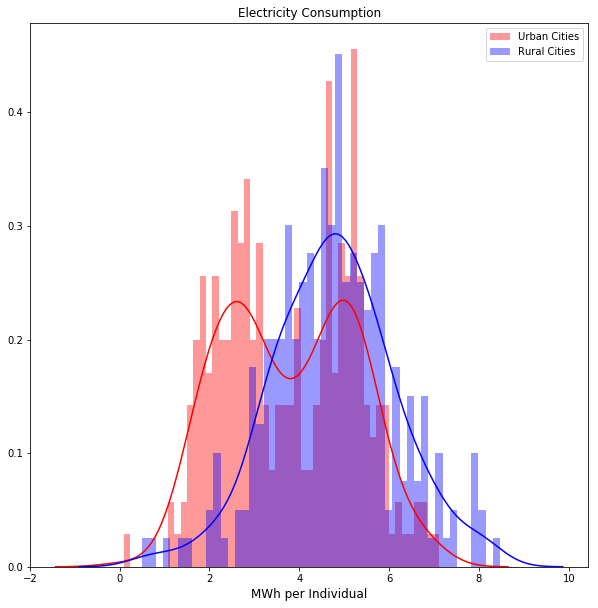

In [200]:
plt.figure(figsize=(10,10))
sns.distplot(y, label='Urban Cities', color='r', bins=50).set_title('Electricity Consumption')
sns.distplot(z, label='Rural Cities', color='b', bins=50)
plt.xlabel('MWh per Individual', fontsize=12)
plt.legend();

In [162]:
clean_rdf.corr(method ='pearson') 

,population,housing_units,elec_mwh,elec_lb_ghg,elec_per_person,ghg_per_person
population,1.000000,0.984562,0.931516,0.892108,-0.097771,-0.168812
housing_units,0.984562,1.000000,0.940104,0.893317,-0.054022,-0.133234
elec_mwh,0.931516,0.940104,1.000000,0.931619,0.082800,-0.022519
elec_lb_ghg,0.892108,0.893317,0.931619,1.000000,0.099667,0.053754
elec_per_person,-0.097771,-0.054022,0.082800,0.099667,1.000000,0.852399
ghg_per_person,-0.168812,-0.133234,-0.022519,0.053754,0.852399,1.000000


In [202]:
clean_rdf.head()

,city,state,population,housing_units,elec_mwh,elec_lb_ghg,elec_per_person,ghg_per_person
11,San Francisco,CA,808976,356797.0,1326629.0,1.776369e+09,1.639887,2195.824097
12,Jacksonville,FL,807815,322002.0,4430020.0,2.147484e+09,5.483954,2658.385456
13,Austin,TX,757688,356573.0,3755068.0,2.147484e+09,4.955955,2834.258490
14,Columbus,OH,754885,337840.0,3276817.0,2.147484e+09,4.340816,2844.782513
15,Fort Worth,TX,703073,276975.0,3742151.0,2.147484e+09,5.322564,3054.424856


In [221]:
clean_rdf['elec_per_res_building'] =  clean_rdf['elec_mwh'] / clean_rdf['housing_units']

In [222]:
clean_rdf['people_per_building'] = clean_rdf['population'] / clean_rdf['housing_units']

In [228]:
clean_rdf.sort_values('elec_per_res_building', ascending=False).head(10)

,city,state,population,housing_units,elec_mwh,elec_lb_ghg,elec_per_person,ghg_per_person,elec_per_house,elec_per_res_building,people_per_building
4673,Hunters Creek Village,TX,4577,1563.0,38750.0,51886536.0,8.466244,11336.363557,0.040335,24.792067,2.928343
2468,East Wenatchee,WA,12286,4982.0,115486.0,142442600.0,9.399805,11593.895491,0.043139,23.180650,2.466078
1765,Pinecrest,FL,18614,6022.0,137127.0,193487637.0,7.366874,10394.737133,0.043915,22.771006,3.091000
1424,Parkland,FL,24017,8591.0,191248.0,269852562.0,7.963026,11235.897989,0.044921,22.261436,2.795600
3910,Crete,NE,6241,2340.0,51715.0,55974338.0,8.286332,8968.809165,0.045248,22.100427,2.667094
3024,Highland Park,TX,9184,3501.0,74111.0,99234852.0,8.069578,10805.188589,0.047240,21.168523,2.623250
1366,University Park,TX,24853,7495.0,158306.0,211972340.0,6.369694,8529.044381,0.047345,21.121548,3.315944
3570,Southwest Ranches,FL,7229,2294.0,48377.0,68260936.0,6.692074,9442.652649,0.047419,21.088492,3.151264
1281,Southlake,TX,26595,9041.0,188674.0,252634780.0,7.094341,9499.333709,0.047919,20.868709,2.941599
2109,Paradise Valley,AZ,14990,5335.0,108410.0,139232787.0,7.232155,9288.378052,0.049211,20.320525,2.809747


/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


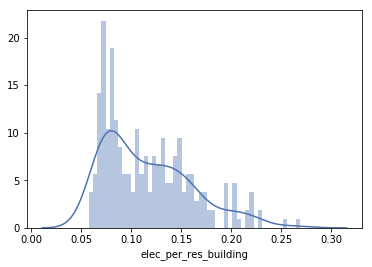

In [210]:
sns.distplot(populous_bois['elec_per_res_building'], bins=50)

/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequen

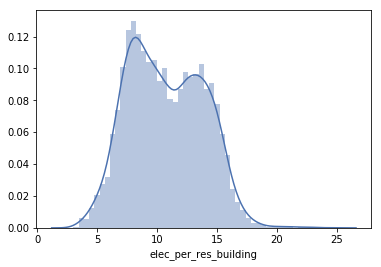

In [226]:
sns.distplot(clean_rdf['elec_per_res_building'], bins=50)

/Users/kylebaranko/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(27.125, 0.5, 'MWh per Residence')

<Figure size 720x720 with 0 Axes>

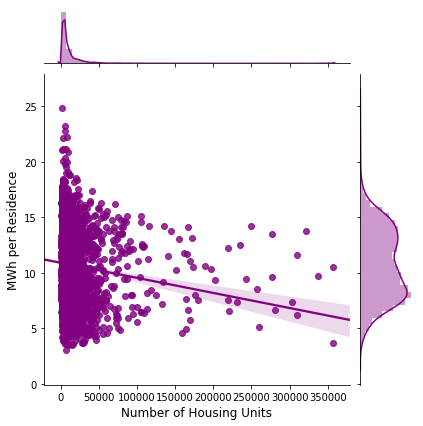

In [245]:
plt.figure(figsize=(10,10))
sns.jointplot(x='housing_units', y='elec_per_res_building', data= clean_rdf, kind="reg", color="purple")
plt.xlabel('Number of Housing Units', fontsize=12)
plt.ylabel('MWh per Residence', fontsize=12)

In [241]:
mu = clean_rdf['elec_per_res_building'].mean()
sigma = clean_rdf['elec_per_res_building'].std() 
n= len(populous_bois)
x_bar = populous_bois['elec_per_res_building'].mean()
z = (x_bar - mu)/(sigma/math.sqrt(n))

p = stats.norm.cdf(z)

p,z

(1.5644224627095365e-07, -5.115515957508341)

In [236]:
clean_rdf[['elec_per_res_building']]

,elec_per_res_building
11,3.718162
12,13.757741
13,10.530994
14,9.699316
15,13.510790
16,11.634233
17,14.181144
18,9.455429
19,7.594425
20,5.113364


In [239]:
populous_bois[['elec_per_res_building']]

,elec_per_res_building
11,3.718162
12,13.757741
13,10.530994
14,9.699316
15,13.510790
16,11.634233
17,14.181144
18,9.455429
19,7.594425
20,5.113364
